In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import *

In [2]:
quarterly_data = [
    pd.read_csv(
        f'./data/metro-bike-share-trips-2018-q{quarter}.csv',
        parse_dates=True,
        index_col='start_time'
    )
    for quarter in range(1,5)
]
bikeshare_2018 = pd.concat(quarterly_data, sort=False)
bikeshare_2018.head()

,trip_id,duration,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
start_time,,,,,,,,,,,,,,
2018-01-01 00:04:00,65406367,21,2018-01-01 00:25:00,3063,34.049198,-118.252831,3018,34.043732,-118.260139,5889,0,One Way,Walk-up,NaN
2018-01-01 00:05:00,65406366,20,2018-01-01 00:25:00,3063,34.049198,-118.252831,3018,34.043732,-118.260139,6311,0,One Way,Walk-up,NaN
2018-01-01 00:06:00,65406365,19,2018-01-01 00:25:00,3063,34.049198,-118.252831,3018,34.043732,-118.260139,5753,0,One Way,Walk-up,NaN
2018-01-01 00:13:00,65406364,22,2018-01-01 00:35:00,3018,34.043732,-118.260139,3031,34.044701,-118.252441,6220,30,One Way,Monthly Pass,NaN
2018-01-01 00:14:00,65406362,45,2018-01-01 00:59:00,4204,33.988419,-118.451630,4216,34.023392,-118.479637,12436,30,One Way,Monthly Pass,NaN


In [3]:
daily = bikeshare_2018.groupby(pd.Grouper(freq='D')).count()
daily['Total'] = daily['trip_id']
daily = daily[['Total']] # remove other columns

In [4]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [5]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
start_time,,,,,,,,
2018-01-01,781,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02,765,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,717,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2018-01-04,736,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2018-01-05,742,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2017', '2019')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [7]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
start_time,,,,,,,,,
2018-01-01,781,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2018-01-02,765,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,717,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2018-01-04,736,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2018-01-05,742,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


(8, 17)

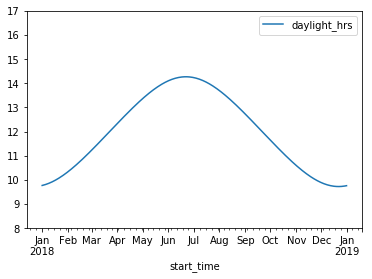

In [8]:
def hours_of_daylight(date, axis=23.44, latitude=34.05):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [9]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [10]:
weather = pd.read_csv('data/DTLA_weather.csv', index_col='DATE', parse_dates=True)
weather['Temp (F)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

daily = daily.join(weather[['PRCP', 'Temp (F)']])

In [11]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'Temp (F)']
X = daily[column_names]
y = daily['Total']

model = LinearRegression()
model.fit(X, y)
daily['predicted'] = model.predict(X)

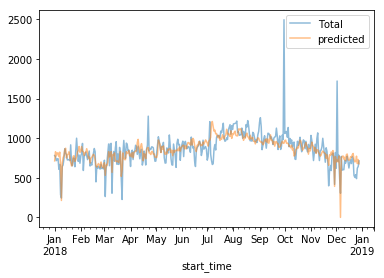

In [12]:
daily[['Total', 'predicted']].plot(alpha=0.5);

In [13]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon             -35.292738
Tue              17.435228
Wed             -15.248530
Thu              14.967416
Fri              22.975737
Sat              -3.681260
Sun              -1.155853
holiday          19.476844
daylight_hrs      9.270321
PRCP           -353.990276
Temp (F)         13.634851
dtype: float64

In [14]:
from sklearn.utils import resample
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

With these errors estimated, let's again look at the results:

In [15]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            -35.0   17.0
Tue             17.0   12.0
Wed            -15.0   13.0
Thu             15.0   16.0
Fri             23.0   16.0
Sat             -4.0   18.0
Sun             -1.0   37.0
holiday         19.0   65.0
daylight_hrs     9.0    5.0
PRCP          -354.0  119.0
Temp (F)        14.0    2.0


In [16]:
ciclavia_dates = pd.to_datetime([
    '2018-4-22',
    '2018-6-24',
    '2018-9-30',
    '2018-12-02'
    
])

In [17]:
ciclavia_dates

DatetimeIndex(['2018-04-22', '2018-06-24', '2018-09-30', '2018-12-02'], dtype='datetime64[ns]', freq=None)

In [18]:
daily['ciclavia'] = 0

In [19]:
for date in ciclavia_dates:
    daily.at[date, 'ciclavia'] = 1

In [20]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'Temp (F)', 'ciclavia']
X = daily[column_names]
y = daily['Total']

model = LinearRegression()
model.fit(X, y)
daily['predicted'] = model.predict(X)

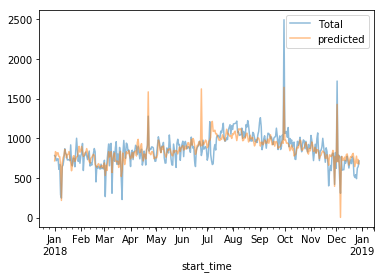

In [21]:
daily[['Total', 'predicted']].plot(alpha=0.5);

In [22]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon             -26.726737
Tue              26.012917
Wed              -6.663692
Thu              23.549078
Fri              31.456964
Sat               4.842230
Sun             -52.470759
holiday          19.208665
daylight_hrs      8.293824
PRCP           -353.815998
Temp (F)         13.781200
ciclavia        763.131037
dtype: float64

In [23]:
from sklearn.utils import resample
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [24]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            -27.0   15.0
Tue             26.0   12.0
Wed             -7.0   12.0
Thu             24.0   14.0
Fri             31.0   16.0
Sat              5.0   18.0
Sun            -52.0   18.0
holiday         19.0   62.0
daylight_hrs     8.0    5.0
PRCP          -354.0  129.0
Temp (F)        14.0    1.0
ciclavia       763.0  377.0
